# Image Classification with CNNs — Kaggle Natural Images (PyTorch)

Author: Marisa Tania

**Dataset:** Kaggle "Natural Images" (8 classes)

This Colab notebook implements:
- Data loading from Kaggle + `ImageFolder`
- Preprocessing: resize, normalization, augmentation
- CNN architecture with BatchNorm + Dropout
- Training loop + early stopping
- Evaluation: accuracy, precision, recall, F1
- Confusion matrix + learning curves
- Simple hyperparameter experiments


## 0) Colab setup

1. **Runtime → Change runtime type → GPU** (recommended)
2. Make sure to have a Kaggle API token (`kaggle.json`) if to download directly in Colab.


In [2]:
import torch, os
print("CUDA available:", torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True
Tesla T4


In [15]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-763581061.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [3]:
# Install Kaggle CLI (for dataset download) and other deps
!pip -q install kaggle

import os, random, time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, accuracy_score
)
import matplotlib.pyplot as plt

SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## 1) Download the Kaggle dataset

Use Kaggle API token to download the dataset in Colab.

In [5]:
import json, os

kaggle_info = {
    "username": "marisatania91",
    "key": "KGAT_6a29453cc6ee817225c0cb803be4e955"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_info, f)

!chmod 600 /root/.kaggle/kaggle.json

print("✅ kaggle.json created successfully")


✅ kaggle.json created successfully


In [6]:
!kaggle datasets list | head


ref                                                            title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                            Chocolate Sales                                         468320  2026-01-04 14:23:35.490000           9996        160  1.0              
adamvakar/apple-comprehensive-financial-dataset-1980-2026      Apple Financial Dataset (1980-2026)                    8508764  2026-01-27 18:45:51.980000            844         28  1.0              
zahranusratt/student-social-media-addiction-analysis-dataset   Student Social Media Addiction Analysis Dataset           7851  2026-01-22 04:02:08.347000           1378         41  1.0              
visha

In [7]:
!kaggle datasets download -d prasunroy/natural-images
!unzip -q natural-images.zip -d natural_images

Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
 88% 300M/342M [00:00<00:00, 833MB/s] 
100% 342M/342M [00:00<00:00, 775MB/s]


## 2) Point to dataset folder

After unzipping, we should have an **ImageFolder** style directory with class subfolders, e.g.:

```
natural_images/
  airplane/
  car/
  cat/
  dog/
  flower/
  fruit/
  motorbike/
  person/
```


In [8]:
DATA_DIR = "/content/natural_images/natural_images"

## 3) Preprocessing: resize, normalization, augmentation

- **Train transforms**: random flip, rotation, color jitter, random resized crop
- **Val/Test transforms**: resize + normalize only


In [9]:
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_WORKERS = 2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


## 4) Load dataset + create Train/Val/Test splits

We split **per class** to keep the class distribution roughly consistent across splits.


In [10]:
base_ds = datasets.ImageFolder(DATA_DIR)  # no transforms for indexing
class_names = base_ds.classes
num_classes = len(class_names)
print('Classes:', class_names)
print('Num classes:', num_classes)
print('Total images:', len(base_ds))


Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Num classes: 8
Total images: 6899


In [11]:
from collections import defaultdict

indices_by_class = defaultdict(list)
for idx, (_, y) in enumerate(base_ds.samples):
    indices_by_class[y].append(idx)

train_idx, val_idx, test_idx = [], [], []
for y, idxs in indices_by_class.items():
    idxs = idxs.copy()
    random.shuffle(idxs)
    n = len(idxs)
    n_train = int(0.70 * n)
    n_val   = int(0.15 * n)
    train_idx += idxs[:n_train]
    val_idx   += idxs[n_train:n_train + n_val]
    test_idx  += idxs[n_train + n_val:]

train_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_DIR, transform=test_tfms)
test_ds  = datasets.ImageFolder(DATA_DIR, transform=test_tfms)

train_subset = Subset(train_ds, train_idx)
val_subset   = Subset(val_ds, val_idx)
test_subset  = Subset(test_ds, test_idx)

print('Train:', len(train_subset), 'Val:', len(val_subset), 'Test:', len(test_subset))


Train: 4826 Val: 1032 Test: 1041


In [12]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_subset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print('Batch X:', xb.shape, 'Batch y:', yb.shape)


Batch X: torch.Size([32, 3, 128, 128]) Batch y: torch.Size([32])


## 5) CNN Architecture (BatchNorm + Dropout)

This is a clean baseline CNN that typically performs well on small-to-medium image datasets.


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, dropout_p: float = 0.35):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=num_classes, dropout_p=0.35).to(device)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

## 6) Training loop + Early Stopping


In [14]:
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    running_loss = 0.0
    all_preds, all_targets = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    return avg_loss, acc, all_targets, all_preds


In [16]:
EPOCHS = 15
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
best_state = None
patience_left = PATIENCE

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer=optimizer)
    va_loss, va_acc, _, _ = run_epoch(model, val_loader,   criterion, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    improved = va_acc > best_val_acc + 1e-4
    if improved:
        best_val_acc = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_left = PATIENCE
    else:
        patience_left -= 1

    dt = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train loss {tr_loss:.6f} acc {tr_acc:.4f} | "
        f"val loss {va_loss:.6f} acc {va_acc:.4f} | {dt:.1f}s"
    )

    if patience_left <= 0:
        print("Early stopping triggered.")
        break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01/15 | train loss 1.133824 acc 0.5957 | val loss 0.725456 acc 0.7393 | 25.6s
Epoch 02/15 | train loss 0.798791 acc 0.7066 | val loss 0.798558 acc 0.7471 | 21.7s
Epoch 03/15 | train loss 0.709256 acc 0.7449 | val loss 0.482647 acc 0.8004 | 20.9s
Epoch 04/15 | train loss 0.628091 acc 0.7594 | val loss 0.824734 acc 0.6948 | 21.6s
Epoch 05/15 | train loss 0.594191 acc 0.7801 | val loss 0.913225 acc 0.6783 | 22.4s
Epoch 06/15 | train loss 0.534030 acc 0.7990 | val loss 0.653052 acc 0.7422 | 21.2s
Epoch 07/15 | train loss 0.523799 acc 0.8002 | val loss 0.310205 acc 0.8731 | 21.5s
Epoch 08/15 | train loss 0.498513 acc 0.8083 | val loss 0.388650 acc 0.8411 | 21.8s
Epoch 09/15 | train loss 0.463483 acc 0.8251 | val loss 0.419881 acc 0.8391 | 21.0s
Epoch 10/15 | train loss 0.456078 acc 0.8218 | val loss 0.782021 acc 0.7393 | 22.3s
Epoch 11/15 | train loss 0.420286 acc 0.8402 | val loss 0.421905 acc 0.8391 | 21.9s
Early stopping triggered.


## 7) Evaluation (accuracy, precision, recall, F1) + classification report


In [17]:
test_loss, test_acc, y_true, y_pred = run_epoch(model, test_loader, criterion, optimizer=None)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Weighted precision: {prec:.4f}")
print(f"Weighted recall: {rec:.4f}")
print(f"Weighted F1: {f1:.4f}")

print('\nClassification report:\n')
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Test loss: 0.2882
Test accuracy: 0.8761
Weighted precision: 0.8841
Weighted recall: 0.8761
Weighted F1: 0.8630

Classification report:

              precision    recall  f1-score   support

    airplane       0.98      0.97      0.98       110
         car       0.99      0.92      0.95       146
         cat       0.57      0.91      0.70       134
         dog       0.64      0.20      0.30       106
      flower       0.96      0.92      0.94       127
       fruit       0.97      1.00      0.99       150
   motorbike       0.95      0.96      0.95       119
      person       0.97      0.98      0.97       149

    accuracy                           0.88      1041
   macro avg       0.88      0.86      0.85      1041
weighted avg       0.88      0.88      0.86      1041



## 8) Confusion Matrix


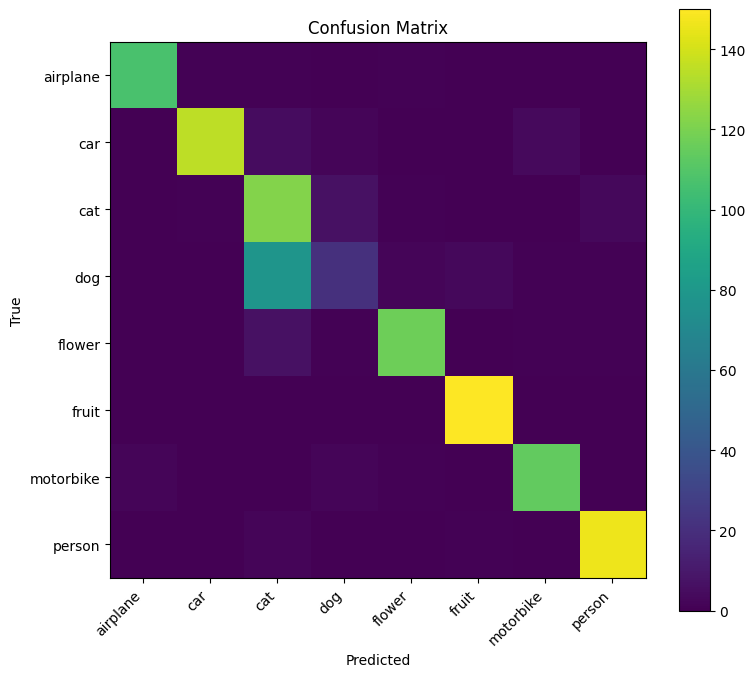

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))
plt.imshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


## 9) Learning Curves (loss + accuracy)


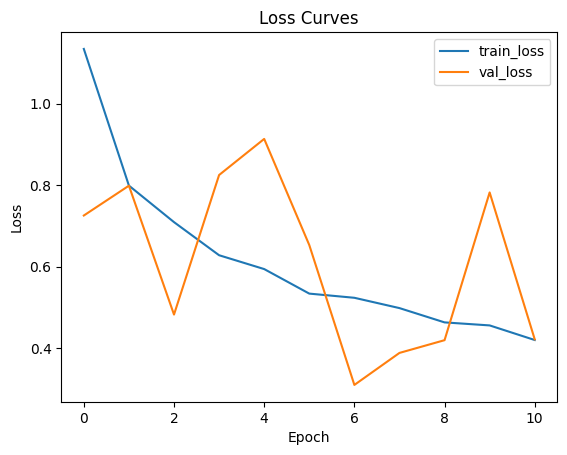

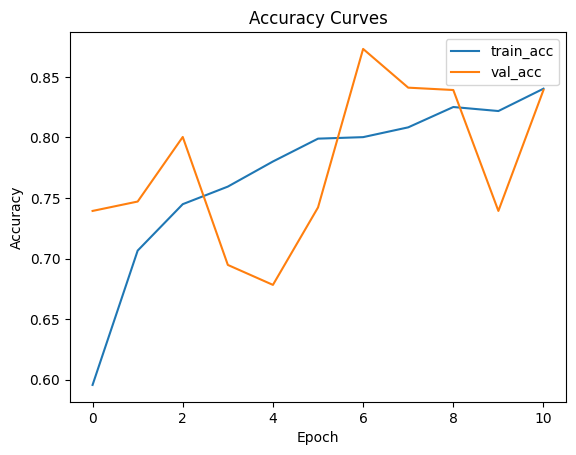

In [19]:
plt.figure()
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 10) Hyperparameter experiments (small grid)

This is a light-weight tuning step, we can expand this grid as needed


In [20]:
def train_one_run(lr, batch_size, dropout_p, epochs=8):
    seed_everything(SEED)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    m = SimpleCNN(num_classes=num_classes, dropout_p=dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(m.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    best_val_loss = float('inf')
    best_val_acc = 0.0

    for _ in range(epochs):
        _ = run_epoch(m, train_loader, criterion, optimizer=optimizer)
        va_loss, va_acc, _, _ = run_epoch(m, val_loader, criterion, optimizer=None)
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            best_val_acc = va_acc

    return best_val_loss, best_val_acc

grid = {
    'lr': [1e-3, 3e-4],
    'batch_size': [32, 64],
    'dropout_p': [0.25, 0.35],
}

results = []
for lr in grid['lr']:
    for bs in grid['batch_size']:
        for dp in grid['dropout_p']:
            val_loss, val_acc = train_one_run(lr, bs, dp, epochs=6)
            results.append((val_acc, val_loss, lr, bs, dp))
            print(f"lr={lr} bs={bs} dropout={dp} => val_acc={val_acc:.4f} val_loss={val_loss:.4f}")

results.sort(reverse=True, key=lambda x: x[0])
best = results[0]
print('\nBest by val_acc:', best)


lr=0.001 bs=32 dropout=0.25 => val_acc=0.8023 val_loss=0.4872
lr=0.001 bs=32 dropout=0.35 => val_acc=0.8314 val_loss=0.4815
lr=0.001 bs=64 dropout=0.25 => val_acc=0.8653 val_loss=0.3474
lr=0.001 bs=64 dropout=0.35 => val_acc=0.8411 val_loss=0.4124
lr=0.0003 bs=32 dropout=0.25 => val_acc=0.8256 val_loss=0.4908
lr=0.0003 bs=32 dropout=0.35 => val_acc=0.8353 val_loss=0.4095
lr=0.0003 bs=64 dropout=0.25 => val_acc=0.8682 val_loss=0.3499
lr=0.0003 bs=64 dropout=0.35 => val_acc=0.8508 val_loss=0.3870

Best by val_acc: (0.8682170542635659, 0.34991313450673756, 0.0003, 64, 0.25)


## 11) ResNet18 Model Comparison experiments

In [21]:
from torchvision import models

def make_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    for p in model.parameters():
        p.requires_grad = False  # freeze backbone

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [22]:
model = make_resnet18(num_classes)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
EPOCHS = 10          # fewer epochs usually enough with transfer learning
LR = 3e-4            # slightly smaller LR works better for fine-tuning
WEIGHT_DECAY = 1e-4
PATIENCE = 3

criterion = nn.CrossEntropyLoss()

# only train the new FC layer (backbone frozen)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
best_state = None
patience_left = PATIENCE

In [24]:
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer=optimizer)
    va_loss, va_acc, _, _ = run_epoch(model, val_loader,   criterion, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    improved = va_acc > best_val_acc + 1e-4
    if improved:
        best_val_acc = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_left = PATIENCE
    else:
        patience_left -= 1

    dt = time.time() - t0
    print(
        f"[ResNet18] Epoch {epoch:02d}/{EPOCHS} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.4f} | {dt:.1f}s"
    )

    if patience_left <= 0:
        print("Early stopping triggered.")
        break


# load best weights
if best_state is not None:
    model.load_state_dict(best_state)

[ResNet18] Epoch 01/10 | train loss 0.9547 acc 0.7694 | val loss 0.2329 acc 0.9767 | 32.4s
[ResNet18] Epoch 02/10 | train loss 0.2949 acc 0.9484 | val loss 0.1056 acc 0.9855 | 26.2s
[ResNet18] Epoch 03/10 | train loss 0.1897 acc 0.9681 | val loss 0.0814 acc 0.9855 | 22.1s
[ResNet18] Epoch 04/10 | train loss 0.1534 acc 0.9660 | val loss 0.0599 acc 0.9874 | 22.2s
[ResNet18] Epoch 05/10 | train loss 0.1301 acc 0.9683 | val loss 0.0535 acc 0.9874 | 21.1s
[ResNet18] Epoch 06/10 | train loss 0.1134 acc 0.9741 | val loss 0.0427 acc 0.9922 | 22.9s
[ResNet18] Epoch 07/10 | train loss 0.0990 acc 0.9764 | val loss 0.0416 acc 0.9903 | 22.7s
[ResNet18] Epoch 08/10 | train loss 0.0895 acc 0.9766 | val loss 0.0393 acc 0.9903 | 21.2s
[ResNet18] Epoch 09/10 | train loss 0.0901 acc 0.9749 | val loss 0.0336 acc 0.9922 | 23.0s
Early stopping triggered.


In [25]:
test_loss, test_acc, y_true, y_pred = run_epoch(model, test_loader, criterion, optimizer=None)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print("\n===== ResNet18 Test Results =====")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Weighted precision: {prec:.4f}")
print(f"Weighted recall: {rec:.4f}")
print(f"Weighted F1: {f1:.4f}")


===== ResNet18 Test Results =====
Test loss: 0.0421
Test accuracy: 0.9904
Weighted precision: 0.9904
Weighted recall: 0.9904
Weighted F1: 0.9904


The pretrained ResNet-18 model achieved substantially higher performance, reaching approximately 99% validation accuracy compared to 87.6% for the custom CNN.